# 物体检测
## 目标检测和图片分类的区别
- 图片分类：

在图像分类任务中，假设图像中只有一个主要物体对象，目标是识别出这个主要物体对象的类别（其他东西相对来说就不那么重要了）

- 目标检测：

在目标检测任务中，一张图像里往往不只一个感兴趣的物体对象，目标不仅仅是识别图像中所有感兴趣的物体（找出所有感兴趣的物体），还要找出它们在图像中所在的具体位置（通过方框来表示）

## 目标检测的应用
无人驾驶：通过识别拍摄到的视频图像中的车辆、行人、道路和障碍物的位置来规划行进路线
无人售后：通过目标检测识别客户选购的物品
机器人通常通过目标检测来检测感兴趣的目标
安防领域使用目标检测来检测异常目标，比如歹徒或者炸弹

## 边缘框（boundingbox）
- 在目标检测中，通常使用边界框来描述对象的空间位置
- 边界框是矩形的


边缘框可以用四个数字来定义（两种常用的表示方法）
- （左上x，左上y，右下x，右下y）
- （中心x，中心y，宽，高）

正方向
- 对于 x 轴来说，向右为 x 轴的正方向，即 x 的值从左到右依次增大
- 对于 y 轴来说，向下为 y 轴的正方向，y 的值从上到下依次增大

# 目标检测数据集
- 目标检测领域没有像MNIST和Fashion-MNIST那样的小数据集
- 目标检测的数据集通常来说比图片分类的数据集小很多，因为标注的成本很高
- 对于图片分类来说，最简单的就是给定一个CSV文件（图片与标号一一对应）或者是给定一个文件夹（每个类对应一个子文件夹，对应标号的图片放在子文件夹下）
- 对于目标检测来说就不能简单的用文件夹的形式，因为一张图片中可能存在多个类，所以就不能放在子文件夹中，所以通常来说目标检测的数据集的标号需要额外存储
- 假设使用文本文件存储的话，每一行表示一个物体，每一行分别由图片文件名（因为一张图片中可能有多个物体，所以同一个文件名可能会出现多次）、物体类别（标号）、边缘框（图片中物体的位置）组成，每一行一共有6（1+1+4）个值


## COCO数据集
目标检测中比较常见的数据集，类似于Imagenet在图片分类中的地位

[访问地址:https://cocodataset.org/#home](https://cocodataset.org/#home)

COCO数据集中有 80 个类别，330k 图片，1.5M 物体（每张图片中有多个物体）

## 总结
- 物体检测不仅能够识别图片所有感兴趣的物体的类别，还能够识别他们的位置，该位置通常由矩形边框表示
- 位置通常用边缘框表示（通常有四个数字）
- 用于目标检测的数据加载与图像分类的数据加载类似，但是，在目标检测中，标签还包含真实边界框的信息，它不出现在图像分类中

# 代码

In [1]:
%matplotlib inline
import torch
import d2l_source.d2l as d2l

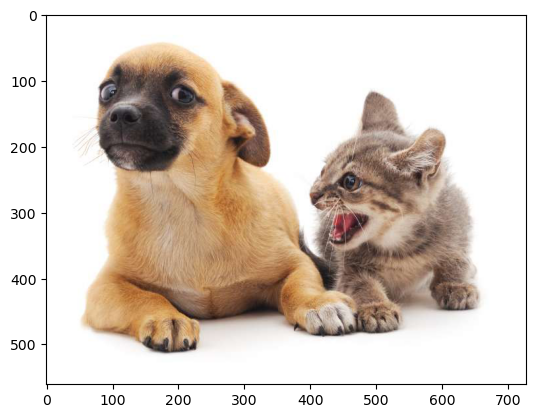

In [2]:
d2l.set_figsize
img = d2l.plt.imread('../data/img/catdog.jpg')
d2l.plt.imshow(img)

边界框

In [3]:
#@save
def box_corner_to_center(boxes):
    """从（左上，右下）转换到（中间，宽度，高度）"""
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1
    boxes = torch.stack((cx, cy, w, h), axis=-1)
    return boxes

#@save
def box_center_to_corner(boxes):
    """从（中间，宽度，高度）转换到（左上，右下）"""
    cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    boxes = torch.stack((x1, y1, x2, y2), axis=-1)
    return boxes

In [4]:
# bbox是边界框的英文缩写
dog_bbox, cat_bbox = [60.0, 45.0, 378.0, 516.0], [400.0, 112.0, 655.0, 493.0]

In [5]:
boxes = torch.tensor((dog_bbox, cat_bbox))
box_center_to_corner(box_corner_to_center(boxes)) == boxes

tensor([[True, True, True, True],
        [True, True, True, True]])

In [6]:
#@save
def bbox_to_rect(bbox, color):
    # 将边界框(左上x,左上y,右下x,右下y)格式转换成matplotlib格式：
    # ((左上x,左上y),宽,高)
    return d2l.plt.Rectangle(
        xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
        fill=False, edgecolor=color, linewidth=2)

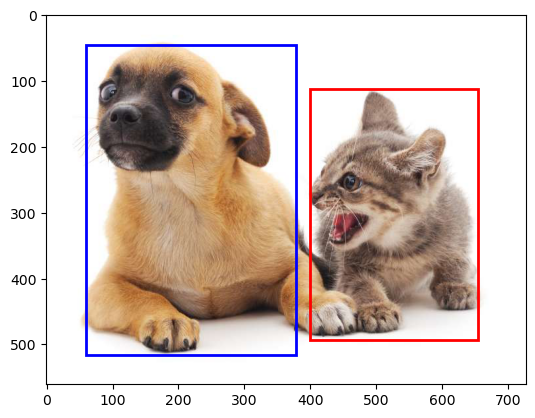

In [7]:
fig = d2l.plt.imshow(img)
fig.axes.add_patch(bbox_to_rect(dog_bbox, 'blue'))
fig.axes.add_patch(bbox_to_rect(cat_bbox, 'red'))

# 目标检测数据集

In [8]:
%matplotlib inline
import os
import pandas as pd
import torch
import torchvision
import d2l_source.d2l as d2l

In [9]:
#@save
d2l.DATA_HUB['banana-detection'] = (
    d2l.DATA_URL + 'banana-detection.zip',
    '5de26c8fce5ccdea9f91267273464dc968d20d72')

读取数据集

In [10]:
#@save
def read_data_bananas(is_train=True):
    """读取香蕉检测数据集中的图像和标签"""
    data_dir = d2l.download_extract('banana-detection')
    csv_fname = os.path.join(data_dir, 'bananas_train' if is_train
                             else 'bananas_val', 'label.csv')
    csv_data = pd.read_csv(csv_fname)
    csv_data = csv_data.set_index('img_name')
    images, targets = [], []
    for img_name, target in csv_data.iterrows():
        images.append(torchvision.io.read_image(
            os.path.join(data_dir, 'bananas_train' if is_train else
                         'bananas_val', 'images', f'{img_name}')))
        # 这里的target包含（类别，左上角x，左上角y，右下角x，右下角y），
        # 其中所有图像都具有相同的香蕉类（索引为0）
        targets.append(list(target))
    return images, torch.tensor(targets).unsqueeze(1) / 256

In [11]:
#@save
class BananasDataset(torch.utils.data.Dataset):
    """一个用于加载香蕉检测数据集的自定义数据集"""
    def __init__(self, is_train):
        self.features, self.labels = read_data_bananas(is_train)
        print('read ' + str(len(self.features)) + (f' training examples' if
              is_train else f' validation examples'))

    def __getitem__(self, idx):
        return (self.features[idx].float(), self.labels[idx])

    def __len__(self):
        return len(self.features)

加载训练集，数据集


In [12]:
#@save
def load_data_bananas(batch_size):
    """加载香蕉检测数据集"""
    train_iter = torch.utils.data.DataLoader(BananasDataset(is_train=True),
                                             batch_size, shuffle=True)
    val_iter = torch.utils.data.DataLoader(BananasDataset(is_train=False),
                                           batch_size)
    return train_iter, val_iter

读取小批量，打印图像和标签的形状

In [13]:
batch_size, edge_size = 32, 256
train_iter, _ = load_data_bananas(batch_size)
batch = next(iter(train_iter))
batch[0].shape, batch[1].shape

read 1000 training examples
read 100 validation examples


(torch.Size([32, 3, 256, 256]), torch.Size([32, 1, 5]))

演示

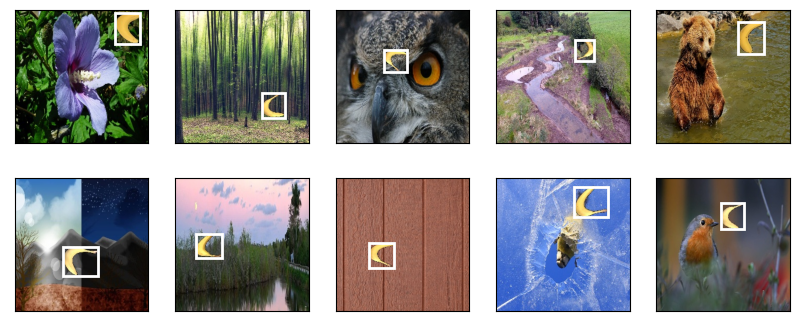

In [14]:
imgs = (batch[0][0:10].permute(0, 2, 3, 1)) / 255
axes = d2l.show_images(imgs, 2, 5, scale=2)
for ax, label in zip(axes, batch[1][0:10]):
    d2l.show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])